In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer as WNL
import scipy
from IPython.display import clear_output as clr
%matplotlib inline

In [2]:
# Defining data directory
data_dir = os.getcwd() + '/../'
# Check in contents of current dir are same as expected
os.listdir(data_dir)

['.ipynb_checkpoints',
 '20news-18828.tar.gz',
 'corpuses',
 'LDA',
 'stackoverflow-data-idf.json',
 'stackoverflow-test.json',
 'TF-IDF',
 'train_corpus',
 'Unigram']

In [276]:
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer as WNL

In [277]:
class preprocessor:
    
    def __init__(self):
        # word lemmatizer
        self.articles = 'a|an|and|the'
        self.lemmatizer = WNL()
        self.punctuations = string.punctuation
        self.translator = str.maketrans(string.punctuation, ' '*len(self.punctuations))
        
    def normalize_text(self, s):
        lower_s = self.lower(s)
        rem_p_s = self.remove_punc(lower_s)
        rem_a_s = self.remove_articles(rem_p_s)
        space_s = self.white_space_fix(rem_a_s)
        lemma_s = self.lemmatize(space_s)
        return lemma_s
        
    def lemmatize(self, txt):
        lemmatizer = self.lemmatizer
        return ' '.join(lemmatizer.lemmatize(lemmatizer.lemmatize(word, pos = 'v'), pos = 'a') for word in txt.split())

    def remove_articles(self, text):
        return re.sub('\s+('+self.articles+')(\s+)', ' ',text)

    def white_space_fix(self, text):
        return ' '.join(text.split())

    def remove_punc(self, text):
        return text.translate(self.translator)

    def lower(self, text):
        return text.lower()

In [278]:
processor = preprocessor()

In [279]:
from nltk.corpus import brown
 
data = []
 
for fileid in brown.fileids():
    document = ' '.join(brown.words(fileid))
    data.append(processor.normalize_text(document))
#     if(len(data) >= 5):
#         break

In [280]:
len(data)

500

In [281]:
class vocab:
    
    def __init__(self, corpus):
        """
        Corpus : list of docs
        """
        self.dictionary = {}
        self.vocab_size = 0
        self.make_vocab(corpus)
        self.inv_dictionary = {v: k for k, v in self.dictionary.items()}
    
    def make_vocab(self,corpus):
        
        count = 0
        for doc in corpus:
            for word in doc.strip().split():
                if(word in self.dictionary.keys()):
                    pass
                else:
                    self.dictionary[word] = count
                    count += 1
        
        self.vocab_size = count
        assert(len(self.dictionary.keys()) == count), "Wrong Number of words added"
        
    def get_index(self,word):
        if(word in self.dictionary.keys()):
            return self.dictionary[word]
        else:
            return -1
    
    def get_word(self,index):
        if(index in self.inv_dictionary.keys()):
            return self.inv_dictionary[index]
        else:
            return " "

In [282]:
myDict = vocab(data)

In [283]:
myDict.vocab_size

34110

In [417]:
def elbo_doc(alpha, beta, phi, gamma, W):
    """
    alpha : Kx1 vec
    beta : KxV mat
    phi : NxK mat
    W : NxV mat
    """
    K, V = beta.shape
    
    gamma_diff = (scipy.special.digamma(gamma) - scipy.special.digamma(np.sum(gamma)))
    phi_w = np.dot(phi.T, W)
    
    loss = 0
    loss += scipy.special.loggamma(np.sum(alpha))
    loss -= np.sum(scipy.special.loggamma(alpha))
    loss += np.sum((alpha - 1)*gamma_diff)
    loss += np.sum(phi.T*gamma_diff)
    loss += np.sum(phi_w * np.log(beta))
    loss -= scipy.special.loggamma(np.sum(gamma))
    loss += np.sum(scipy.special.loggamma(gamma))
    loss -= np.sum((gamma - 1)*gamma_diff)
    loss -= np.sum(phi*np.log(phi + 10e-12))
    
    return loss

In [461]:
class LDA:
    
    def __init__(self,vocab, K):
        """
        vocab : a dictionary class containing all the words and corresponding indices
        k : smoothing parameter for beta matrix
        """
        self.eps = 10e-8
        self.tol = 0.001
        self.vocab = vocab
        self.V = vocab.vocab_size
        self.K = K
        self.alpha = np.zeros((self.K, 1)) + np.random.rand()
        beta = np.random.rand(self.K, self.V)
        beta = beta/(np.sum(beta,  axis = 1).reshape(-1,1) + self.eps)
        self.beta = beta
        
        self.gamma = np.random.rand(self.K , 1)
        self.digamma = scipy.special.digamma
        self.polygamma = scipy.special.polygamma
        self.elbo_loss = []
        
        
    def train(self, corpus, epochs = 1):
        
        """
        Corpus : List of documents
        epochs : max_number of epochs
        """
        
        max_iter_inner = 1000
        max_iter_inner_a = 1
        
        M = len(corpus)
        
        for epoch in range(epochs):
            
            
            elbo_net = 0
            
            beta = np.zeros((self.K, self.V))
            grad_alpha = 0*self.alpha
            hesn_alpha = np.zeros((self.K, self.K))
            print("Initialized")
            count = 0
            
            for doc in corpus:
                clr(wait = True)
                count += 1
                print("epoch : ", epoch, " doc init: ", count)
                words = doc.strip().split(" ")
                N = len(words)
                phi = np.zeros((N, self.K)) + 1/self.K
                gamma = self.alpha + N/self.K
                w = np.zeros((N, self.V))
                

                beta_d = np.zeros((self.K, N))
                for j, word in enumerate(words):
                    index = self.vocab.get_index(word)
                    beta_v = (self.beta[:,index].reshape(self.K))
                    beta_d[:,j] = beta_v
                    w[j, index] = 1
                
                new_norm = self.norm(gamma)
                old_norm = new_norm  + 20
                diff = 20
                count_inner = 0
                while(diff > self.tol and count_inner < max_iter_inner):
                    
                    phi = self.calc_phi(beta_d, gamma).T
                    gamma = self.alpha + np.sum(phi , axis = 0).reshape(self.K, 1)
                    old_norm = new_norm
                    new_norm = self.norm(gamma)
                    diff = np.abs(new_norm - old_norm)
                    count_inner += 1
                    
                    if(count_inner == max_iter_inner):
                        print('Not converged')


                print("epoch : ", epoch, "made gamma and phi converge ", count)
                

                beta = beta+np.dot(phi.T, w)
                
                        
                print("epoch : ", epoch, "made beta", count)

                
                grad_alpha += self.digamma(np.sum(self.alpha)) - self.digamma(self.alpha)
                grad_alpha += self.digamma(gamma) - self.digamma(np.sum(gamma))
                
                elbo_c_doc = elbo_doc(self.alpha, self.beta, phi, gamma, w)
                elbo_net += elbo_c_doc

                
            beta = beta/(np.sum(beta,  axis = 1).reshape(-1,1) + self.eps)
           
        
            alpha = self.alpha
            alpha_old = self.norm(alpha)+20
            alpha_new = self.norm(alpha)
            diff = 10
            inner_iter_alpha = 0
            while(diff > self.tol and inner_iter_alpha < max_iter_inner_a):
                hess_alpha = np.diag(M*scipy.special.polygamma(1,alpha).reshape(-1)) - scipy.special.polygamma(1,np.sum(alpha))
                alpha -= np.dot(np.linalg.pinv(hess_alpha + np.eye(hess_alpha.shape[0])*self.eps),grad_alpha.reshape(-1,1))
                alpha_old = alpha_new
                alpha_new = self.norm(alpha)
                inner_iter_alpha += 1
                if(inner_iter_alpha == max_iter_inner):
                        print('Not converged')


            # update params
            self.beta = beta
            self.gamma = gamma
            self.alpha = alpha
            
            self.elbo_loss.append(elbo_net)
            

    def calc_phi(self, beta_v, gamma):
        phi = np.exp(self.digamma(gamma) - self.digamma(np.sum(gamma))).reshape(self.K,1)
        phi = beta_v*phi
        phi = phi/(np.sum(phi, axis = 0) + self.eps)
        return phi
    
    def norm(self, a):
        sqr = np.square(a)
        return np.sqrt(np.sum(sqr))

In [533]:
model = LDA(myDict , 20)

In [534]:
model.train(data[:5], epochs= 5)

epoch :  4  doc init:  5
epoch :  4 made gamma and phi converge  5
epoch :  4 made beta 5


In [577]:
model.elbo_loss

[-93661.86957047437, nan, nan, nan, nan]

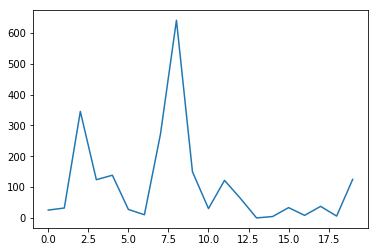

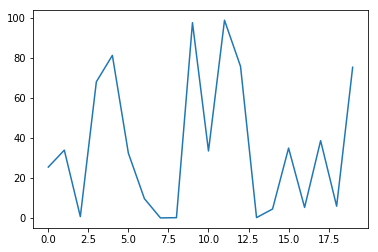

In [578]:
plt.plot(model.gamma)
plt.show()
plt.plot(model.alpha)
plt.show()

In [588]:
indices = np.argsort(model.beta[7])[-10:]

In [589]:
indices

array([ 118, 1642,    5,   40, 1670,   17,   31,   50,    8,  368])

In [590]:
for i in indices:
    print(myDict.get_word(i))

should
track
say
be
mr
that
have
to
of
he


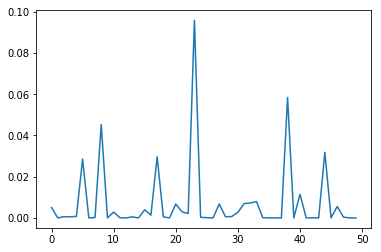

In [594]:
plt.plot(model.beta[19][:50])
plt.show()

In [595]:
class Smooth_LDA:
    
    def __init__(self,vocab, K):
        """
        vocab : a dictionary class containing all the words and corresponding indices
        k : smoothing parameter for beta matrix
        """
        self.eps = 10e-8
        self.tol = 0.001
        self.vocab = vocab
        self.V = vocab.vocab_size
        self.K = K
        self.alpha = np.zeros((self.K, 1)) + np.random.rand()
        beta = np.random.rand(self.K, self.V)
        beta = beta/(np.sum(beta,  axis = 1).reshape(-1,1) + self.eps)
        self.beta = beta
        
        self.ita = 1/self.V
        self.lamda = self.ita*np.ones((self.K,self.V))
        
        self.gamma = np.random.rand(self.K , 1)
        self.digamma = scipy.special.digamma
        self.polygamma = scipy.special.polygamma
        self.elbo_loss = []
        
        
    def train(self, corpus, epochs = 1):
        
        """
        Corpus : List of documents
        epochs : max_number of epochs
        """
        
        max_iter_inner = 1000
        max_iter_inner_a = 1
        
        M = len(corpus)
        
        for epoch in range(epochs):
            
            beta = np.zeros((self.K, self.V))
            grad_alpha = 0*self.alpha
            hesn_alpha = np.zeros((self.K, self.K))
            print("Initialized")
            count = 0
            
            elbo_net = 0
            
            for doc in corpus:
                clr(wait = True)
                count += 1
                print("epoch : ", epoch, " doc init: ", count)
                words = doc.strip().split(" ")
                N = len(words)
                phi = np.zeros((N, self.K)) + 1/self.K
                gamma = self.alpha + N/self.K
                w = np.zeros((N, self.V))
                
                beta_d = np.zeros((self.K, N))
                for j, word in enumerate(words):
                    index = self.vocab.get_index(word)
                    beta_v = (self.beta[:,index].reshape(self.K))
                    beta_d[:,j] = beta_v
                    w[j, index] = 1
                
                new_norm = self.norm(gamma)
                old_norm = new_norm  + 20
                diff = 20
                count_inner = 0
                while(diff > self.tol and count_inner < max_iter_inner):
                    
                    phi = self.calc_phi(beta_d, gamma).T
                    gamma = self.alpha + np.sum(phi , axis = 0).reshape(self.K, 1)
                    old_norm = new_norm
                    new_norm = self.norm(gamma)
                    diff = np.abs(new_norm - old_norm)
                    count_inner += 1
                    if(count_inner == max_iter_inner):
                        print('Not converged')


                print("epoch : ", epoch, "made gamma and phi converge ", count)
                beta = beta+np.dot(phi.T, w)
                
                        
                print("epoch : ", epoch, "made beta", count)

                
                grad_alpha += self.digamma(np.sum(self.alpha)) - self.digamma(self.alpha)
                grad_alpha += self.digamma(gamma) - self.digamma(np.sum(gamma))
                
                elbo_c_doc = elbo_doc(self.alpha, self.beta, phi, gamma, w)
                elbo_net += elbo_c_doc
                

            lamda = self.ita + beta
            beta = np.exp(self.digamma(lamda)- self.digamma(np.sum(lamda,axis = 1)).reshape(-1,1))
            beta = beta/(np.sum(beta,  axis = 1).reshape(-1,1) + self.eps).reshape(-1,1)
            
            alpha = self.alpha
            alpha_old = self.norm(alpha)+20
            alpha_new = self.norm(alpha)
            diff = 10
            inner_iter_alpha = 0
            while(diff > self.tol and inner_iter_alpha < max_iter_inner_a):
                hess_alpha = np.diag(M*scipy.special.polygamma(1,alpha).reshape(-1)) - scipy.special.polygamma(1,np.sum(alpha))
                alpha -= np.dot(np.linalg.inv(hess_alpha + np.eye(hess_alpha.shape[0])*self.eps),grad_alpha.reshape(-1,1))
                alpha_old = alpha_new
                alpha_new = self.norm(alpha)
                inner_iter_alpha += 1
                if(inner_iter_alpha == max_iter_inner):
                        print('Not converged')
                
            
            # update params
            self.beta = beta
            self.gamma = gamma
            self.alpha = alpha
            self.lamda = lamda
            self.elbo_loss.append(elbo_net)
            

    def calc_phi(self, beta_v, gamma):
        phi = np.exp(self.digamma(gamma) - self.digamma(np.sum(gamma))).reshape(self.K,1)
        phi = beta_v*phi
        phi = phi/(np.sum(phi, axis = 0) + self.eps)
        return phi
    
    def norm(self, a):
        sqr = np.square(a)
        return np.sqrt(np.sum(sqr))

In [574]:
s_model = Smooth_LDA(myDict , 50)

In [575]:
s_model.train(data, epochs= 5)

epoch :  4  doc init:  500
epoch :  4 made gamma and phi converge  500
epoch :  4 made beta 500


In [624]:
indices = np.argsort(s_model.beta[6])[0:10]

In [625]:
for i in indices:
    print(myDict.get_word(i))

nutmeg
depiction
litz
ching
oracles
intensities
rotations
serial
perceptual
urgencies


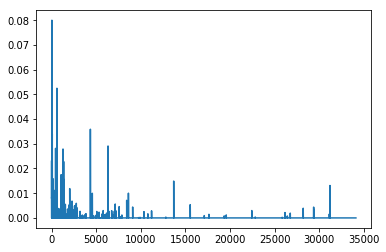

In [611]:
plt.plot(s_model.beta[7])
plt.show()

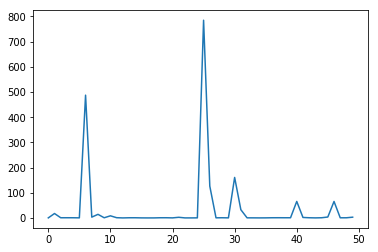

In [603]:
plt.plot(s_model.gamma)

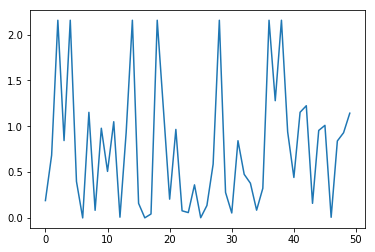

In [600]:
plt.plot(s_model.alpha)

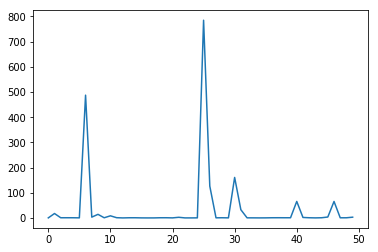

In [631]:
plt.plot(s_model.gamma)

In [372]:
from sklearn.decomposition import LatentDirichletAllocation as sk_LDA

In [375]:
model_sk = sk_LDA(n_components=5)

In [401]:
w_arr = np.array([myDict.get_index(word) for doc in data for word in doc.strip().split(" ")[:300]]).reshape(-1,500)

In [402]:
w_arr.shape

(300, 500)

In [403]:
model_sk.fit(w_arr)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [404]:
transformed = model_sk.transform(w_arr)

In [405]:
transformed.shape

(300, 5)

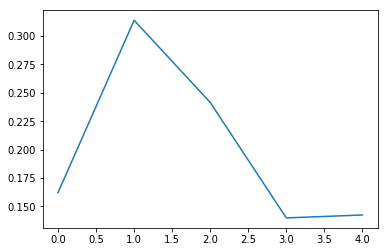

In [408]:
plt.plot(transformed[8])